# Learn Generative Adversarial Network

## 1. Import Dependencies and Data

In [65]:
# Importing the libraries
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [66]:
from tensorflow.keras.datasets import fashion_mnist
from matplotlib import pyplot as plt

(train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()
train_X.shape, test_X.shape

((60000, 28, 28), (10000, 28, 28))

## 2. Visualization data dan create dataset

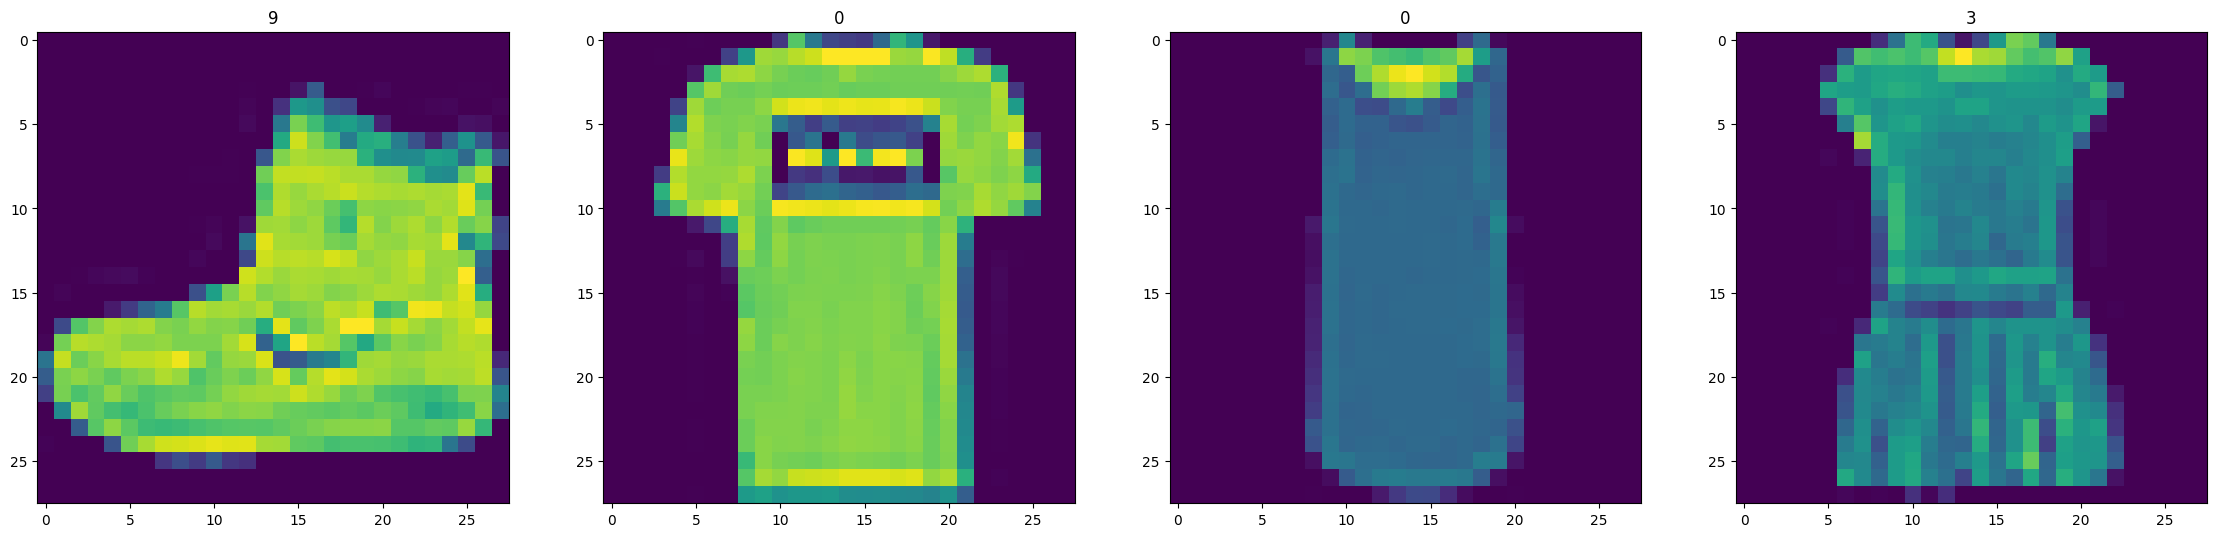

In [67]:
import numpy as np

fig, ax = plt.subplots(ncols=4, figsize=(28,28))
for idx in range(4):
    ax[idx].imshow(train_X[idx])
    ax[idx].set_title(train_y[idx])

In [68]:
# Rescale pixel values
train_X = train_X.astype('float32')/255.0
test_X = test_X.astype('float32')/255.0

# Convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
train_y = tf.keras.utils.to_categorical(train_y, num_classes=10)
test_y = tf.keras.utils.to_categorical(test_y, num_classes=10)

# Create a tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))

# Suffle the dataset
buffer_size = 60000
train_dataset = train_dataset.shuffle(buffer_size).batch(128)
train_dataset = train_dataset.prefetch(64)

train_dataset.as_numpy_iterator().next()[0].shape

(128, 28, 28)

## 3. Build Neural Network

### 3.1 Import Modeling Component

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### 3.2 Build Generator

In [86]:
def BuildGenerator():
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginning of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=5, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=5, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # Convolutional Block 1
    model.add(Conv2D(128, kernel_size=4, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # Convolutional Block 2
    model.add(Conv2D(128, kernel_size=4, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # Conv layer to one channel
    model.add(Conv2D(1, kernel_size=4, padding='same', activation='sigmoid'))
    
    return model

In [87]:
generator = BuildGenerator()
generator.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 6272)              809088    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 128)       409728    
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, 28, 28, 128)      

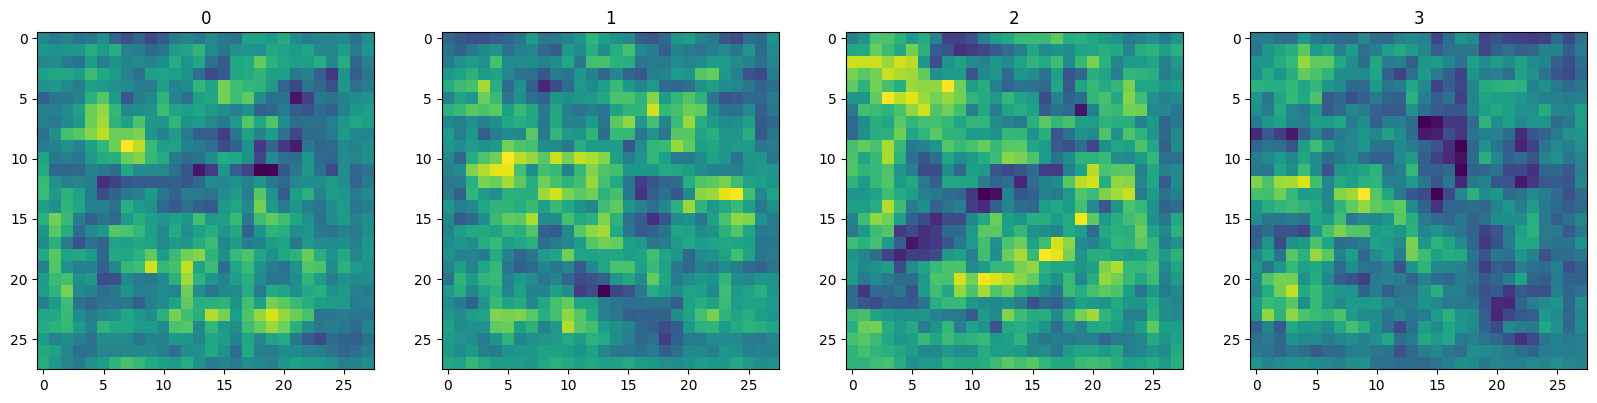

In [89]:
img = generator.predict(np.random.randn(4,128))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

### 3.3 Build Discriminator

In [90]:
def BuildDiscriminator():
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape=(28,28,1)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64,5))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128,5))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    # Forth Conv Block
    model.add(Conv2D(256,5))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [91]:
discriminator = BuildDiscriminator()
discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 20, 20, 64)        51264     
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 128)     

In [92]:
img.shape

(28, 28, 1)

In [93]:
discriminator.predict(img.reshape(1,28,28,1))

array([[0.498705]], dtype=float32)